In [ ]:
# 그래프에서 한글표현을 위해 폰트를 설치합니다.
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum.
(Reading database ... 155569 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)

plt.rc('font', family=font_name)

fm._rebuild()

NanumGothic Eco


In [ ]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download the data


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/project/NLP_project/전처리/music_data_(35만_500자 제한)_re1.csv')

df

,Unnamed: 0,title,lyric
0,0,가,Follow me Here we go I go I go I go 난 완전히 go ...
1,1,가,어서와 포르쉐는 처음이지 yeah I bet that 억짜리 SUV white s...
2,2,잘 가,어서 가 밤이 깊었으니까 그래 조심히 들어가 그렇게 네가 사라질 때까지 손을 흔들...
3,3,가,참 선명한 얘기들 깨어도 깨어지지 않는 조각들 그뿐이란 걸 알면 이제 그만해도 될...
4,4,가,미안하다는 사과도 잘하겠다는 네 말도 지겨워 다 Over and over agai...
...,...,...,...
341318,341318,나 사는 이유 알도록,어린 시절 성탄 아침에 우린 많은 선물을 받았었지 하지만 몰랐었네 아기예수 탄생하...
341319,341319,나로부터 시작되리,저 높은 하늘위로 밝은 태양 떠오르듯이 난 주저앉지 않으리 어떤 어려움에도 주의 ...
341320,341320,나로부터 시작되리,저 높은 하늘 위로 밝은 태양 떠오르듯이 난 주저앉지 않으리 어떤 어려움에도 주의...
341321,341321,나로부터 시작되리,저 높은 하늘위로 밝은 태양 떠오르듯이 난 주저앉지 않으리 어떤 어려움에도 주의 ...


In [ ]:
df['title'].nunique(), df['lyric'].nunique()
df.drop_duplicates(subset=['lyric'], inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

df

,Unnamed: 0,title,lyric
0,0,가,Follow me Here we go I go I go I go 난 완전히 go ...
1,1,가,어서와 포르쉐는 처음이지 yeah I bet that 억짜리 SUV white s...
2,2,잘 가,어서 가 밤이 깊었으니까 그래 조심히 들어가 그렇게 네가 사라질 때까지 손을 흔들...
3,3,가,참 선명한 얘기들 깨어도 깨어지지 않는 조각들 그뿐이란 걸 알면 이제 그만해도 될...
4,4,가,미안하다는 사과도 잘하겠다는 네 말도 지겨워 다 Over and over agai...
...,...,...,...
341318,341318,나 사는 이유 알도록,어린 시절 성탄 아침에 우린 많은 선물을 받았었지 하지만 몰랐었네 아기예수 탄생하...
341319,341319,나로부터 시작되리,저 높은 하늘위로 밝은 태양 떠오르듯이 난 주저앉지 않으리 어떤 어려움에도 주의 ...
341320,341320,나로부터 시작되리,저 높은 하늘 위로 밝은 태양 떠오르듯이 난 주저앉지 않으리 어떤 어려움에도 주의...
341321,341321,나로부터 시작되리,저 높은 하늘위로 밝은 태양 떠오르듯이 난 주저앉지 않으리 어떤 어려움에도 주의 ...


## Configuration


In [ ]:
batch_size = 32  # Batch size for training.
epochs = 100  # Number of epochs to train for.
hidden_units = 256  # Latent dimensionality of the encoding space.
embedding_dim = 100
num_samples = 341323    # Number of samples to train on.
dropout_rate = 0.4

## Prepare the data


데이터셋을 다운로드한 후에 데이터를 준비하고자 다음의 단계를 수행합니다.

1. 각 문장에 start와 end 토큰을 추가합니다.
2. 특정 문자를 제거함으로써 문장을 정리합니다.
3. 단어 인덱스와 아이디(ID) 인덱스를 생성합니다. (단어 → 아이디(ID), 아이디(ID) → 단어로 매핑된 딕셔너리).
4. 각 문장을 입력층의 최대 길이만큼 패딩(padding)을 수행합니다.

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.9 MB/s 
     |████████████████████████████████| 453 kB 58.4 MB/s 


In [ ]:
from konlpy.tag import Okt
okt = Okt()

In [ ]:
import re
def preprocess_kor_sentence(sent):
  # 단어와 구두점 사이에 공백을 만듭니다.
  # Ex) "he is a boy." => "he is a boy ."
  sent = re.sub(r"([?.!,¿])", r" \1", sent)

  # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
  sent = re.sub(r"[^a-zA-Z가-힣ㄱ-ㅎㅏ-ㅣ!.?]+", r" ", sent)

  # 다수 개의 공백을 하나의 공백으로 치환
  sent = re.sub(r"\s+", " ", sent)
  
  sent = okt.morphs(sent, stem = False)
  sent = " ".join(sent) # string으로 출력!!! 구분 " "
  return sent

In [ ]:
from tqdm import tqdm 
def load_preprocessed_data():
    encoder_input, decoder_input, decoder_target = [], [], []

    for i in tqdm(range(len(df[:num_samples]))):
        # source 데이터와 target 데이터 분리
        tar_line = df['title'].iloc[i]
        src_line = df['lyric'].iloc[i]

        # source 데이터 전처리
        src_line = [w for w in preprocess_kor_sentence(src_line).split()]

        # target 데이터 전처리
        tar_line = preprocess_kor_sentence(tar_line)
        tar_line_in = [w for w in ("<sos> " + tar_line).split()]  # teacher forcing을 위한 정답셋 
        tar_line_out = [w for w in (tar_line + " <eos>").split()]

        encoder_input.append(src_line)
        decoder_input.append(tar_line_in)
        decoder_target.append(tar_line_out)
                
    return encoder_input, decoder_input, decoder_target

In [ ]:
# 전처리 테스트

kr_sent = u"저녁 먹었니?"

print('전처리 전 한국어 문장 :', kr_sent)
print('전처리 후 한국어 문장 :', preprocess_kor_sentence(kr_sent))

전처리 전 한국어 문장 : 저녁 먹었니?
전처리 후 한국어 문장 : 저녁 먹었니 ?


In [ ]:
sents_lylic_in, sents_title_in, sents_title_out  = load_preprocessed_data()

100%|██████████| 341323/341323 [6:04:15<00:00, 15.62it/s]


In [ ]:
len(sents_lylic_in), len(sents_title_in), len(sents_title_out)

(341323, 341323, 341323)

In [ ]:
print('인코더의 입력 :',sents_lylic_in[2968])
print('디코더의 입력 :',sents_title_in[2968])
print('디코더의 레이블 :',sents_title_out[2968])

인코더의 입력 : ['궂', '은', '비', '내리는', '날', '그야말로', '옛날', '식', '다방', '에', '앉아', '도라지', '위스키', '한', '잔', '에다', '짙은', '색소폰', '소릴', '들어', '보렴', '새', '빨', '간', '립스틱', '에', '나름', '대로', '멋', '을', '부린', '마담', '에게', '실없이', '던지는', '농담', '사이', '로', '짙은', '색소폰', '소릴', '들어', '보렴', '이제', '와', '새삼', '이', '나이', '에', '실연', '의', '달콤함이야', '있', '겠냐만은', '왠지', '한', '곳', '이', '비어', '있는', '내', '가슴', '이', '잃어버린', '것', '에', '대하', '여', '밤', '늦은', '항구', '에서', '그야말로', '연락선', '선', '창가', '에서', '돌아올', '사람', '은', '없을지라도', '슬픈', '뱃고동', '소릴', '들어', '보렴', '첫사랑', '그', '소녀', '는', '어디', '에서', '나', '처럼', '늙어', '갈까', '가버린', '세월', '이', '서글퍼지는', '슬픈', '뱃고동', '소릴', '들어', '보렴', '이제', '와', '새삼', '이', '나이', '에', '청춘', '의', '미련', '이야', '있', '겠냐만은', '왠지', '한', '곳', '이', '비어', '있는', '내', '가슴', '에', '다시', '못', '올', '곳', '에', '대하', '여', '낭만', '에', '대하', '여', 'kia']
디코더의 입력 : ['<sos>', '낭만', '에', '대하', '여']
디코더의 레이블 : ['낭만', '에', '대하', '여', '<eos>']


단어집합을 생성하겠습니다. 

In [ ]:
# 가사 input -> 제목 output 

# 가사 input

tokenizer_lylic = Tokenizer(filters="", lower=False)
tokenizer_lylic.fit_on_texts(sents_lylic_in)
encoder_input = tokenizer_lylic.texts_to_sequences(sents_lylic_in)

In [ ]:
# 제목 output
tokenizer_title = Tokenizer(filters="", lower=False)
tokenizer_title.fit_on_texts(sents_title_in)
tokenizer_title.fit_on_texts(sents_title_out)

decoder_input = tokenizer_title.texts_to_sequences(sents_title_in)
decoder_target = tokenizer_title.texts_to_sequences(sents_title_out)

각 문장을 입력층의 최대 길이만큼 패딩(padding)을 수행합니다. 

In [ ]:
encoder_input = pad_sequences(encoder_input,maxlen=1500, padding="post")
decoder_input = pad_sequences(decoder_input,maxlen=8, padding="post")
decoder_target = pad_sequences(decoder_target,maxlen=8, padding="post")

In [ ]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

샘플은 총 3833개 존재합니다


In [ ]:
src_vocab_size = len(tokenizer_lylic.word_index) +1
tar_vocab_size = len(tokenizer_title.word_index) +1

print(f"가사 단어 집합의 크기 : {src_vocab_size}, 제목 단어 집합의 크기 : {tar_vocab_size}")

가사 단어 집합의 크기 : 420224, 제목 단어 집합의 크기 : 84752


In [ ]:
len(tokenizer_title.word_index)

단어로부터 정수를 얻는 딕셔너리와 정수로부터 단어를 얻는 딕셔너리를 각각 만들어줍니다. 이들은 훈련을 마치고 예측값과 실제값을 비교하는 단계에서 사용합니다. 

In [ ]:
src_to_index = tokenizer_lylic.word_index  # word : idx
index_to_src = tokenizer_lylic.index_word  # idx : word
tar_to_index = tokenizer_title.word_index # word : idx
index_to_tar = tokenizer_title.index_word # idx : word

In [ ]:
print(len(src_to_index),len(index_to_src),len(tar_to_index),len(index_to_tar))


420223 420223 84751 84751


테스트 데이터를 분리하겠습니다. 인코더 input, 디코더 input, 디코더 output이 동일하게 분리되어야 하기 때문에 랜덤한 정수배열을 만들어 직접 나누겠습니다. 

우선 랜덤하게 시퀀스를 섞습니다. 

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [ 75622 182206 302362 ...   1233 191752  44293]


In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
decoder_input[indices[0]], decoder_target[indices[0]]

(array([4049, 1700, 2971,   52, 3579,  479,   45,    3], dtype=int32),
 array([1700, 2971,   52, 3579,  479,   45,    3,    2], dtype=int32))

`<sos>` `<eos>` 토큰을 제외한 다른 단어들은 동일한 인덱스를 갖고 있어야 합니다. 

10%의 데이터를 test데이터로 분리하겠습니다. 

In [ ]:
n_of_val = int(num_samples*0.1)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [ ]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (307191, 1500)
훈련 target 데이터의 크기 : (307191, 8)
훈련 target 레이블의 크기 : (307191, 8)
테스트 source 데이터의 크기 : (34132, 1500)
테스트 target 데이터의 크기 : (34132, 8)
테스트 target 레이블의 크기 : (34132, 8)


## Model

이제 번역기를 빌드해보겠습니다. 

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

인코더를 설계합니다. LSTM에서 state_h, state_c를 리턴받는데, 이는 각각 RNN 챕터에서 LSTM을 처음 설명할 때 언급하였던 은닉 상태와 셀 상태에 해당됩니다. 이 두 가지 상태를 encoder_states에 저장합니다. encoder_states를 디코더에 전달하므로서 이 두 가지 상태 모두를 디코더로 전달할 예정입니다. 이것이 앞서 배운 컨텍스트 벡터입니다.

In [ ]:
# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
encoder_lstm1 = LSTM(hidden_units, return_sequences = True, return_state=True,dropout = dropout_rate)
encoder_lstm2 = LSTM(hidden_units, return_sequences = True, return_state=True,dropout = dropout_rate)
encoder_lstm3 = LSTM(hidden_units, return_sequences = True, return_state=True,dropout = dropout_rate)
encoder_lstm4 = LSTM(hidden_units, return_sequences = True, return_state=True,dropout = dropout_rate)

x, eh1, ec1 = encoder_lstm1(enc_emb) # 은닉 상태와 셀 상태를 리턴
x, eh2, ec2 = encoder_lstm2(x) # 은닉 상태와 셀 상태를 리턴
x, eh3, ec3 = encoder_lstm3(x) # 은닉 상태와 셀 상태를 리턴
encoder_outputs, eh4, ec4 = encoder_lstm4(x) # 은닉 상태와 셀 상태를 리턴

encoder_states = [eh1, ec1, eh2, ec2, eh3, ec3, eh4, ec4] # 인코더의 은닉 상태와 셀 상태를 저장

이번에는 Attention을 추가합니다. 
- Attention 중 가장 기초적인 dot-product attention을 예제로 진행하겠습니다. 
1. attention score 계산
2. softmax로 attention distribution 계산
3. 각 인코더의 어텐션 가중치와 은닉 상태를 가중합하여 어텐션 값 계산
4. 어텐션값과 디코더의 t시점의 은닉상태를 연결
5. 출력층 연산의 입력이 되는 st 계산

디코더에서는 attention layer를 추가합니다. 
- 이때, s_는 은닉상태와 디코더의 최종 출력은 연결해야 하므로, shape을 맞춰주기 위하여 축을 추가합니다. 
- attention layer는 디코더의 은닉상태와 인코더의 은닉상태 전체를 받아 컨텍스트 벡터를 생성합니다. 
- 마지막으로 생성한 컨텍스트 벡터와 디코더의 은닉상태 전체를 softmax layer에 넣고 인덱스를 예측합니다. 


In [ ]:
dropout_rate

0.4

In [ ]:
from tensorflow.keras.layers import Attention

# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 임베딩 결과

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm1 = LSTM(hidden_units, return_sequences=True, return_state=True , dropout = dropout_rate) 
decoder_lstm2 = LSTM(hidden_units, return_sequences=True, return_state=True , dropout = dropout_rate) 
decoder_lstm3 = LSTM(hidden_units, return_sequences=True, return_state=True , dropout = dropout_rate) 
decoder_lstm4 = LSTM(hidden_units, return_sequences=True, return_state=True , dropout = dropout_rate) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
x1, h1, c1 = decoder_lstm1(dec_emb, initial_state=encoder_states[:2])
x2, h2, c2 = decoder_lstm2(x1, initial_state=encoder_states[2:4])
x3, h3, c3 = decoder_lstm3(x2, initial_state=encoder_states[4:6])
decoder_outputs, h4 , c4 = decoder_lstm4(x3, initial_state=encoder_states[6:])

# attention
S_ = tf.concat([eh4[:, tf.newaxis, :], decoder_outputs[:, :-1, :]], axis=1) # query 

attention = Attention(hidden_units)
context_vector, _ = attention([S_, encoder_outputs], return_attention_scores = True)

concat = tf.concat([decoder_outputs, context_vector], axis=-1)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(concat)

In [ ]:
# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 100)    42022400    ['input_2[0][0]']                
                                                                                                  
 embedding_8 (Embedding)        (None, None, 256)    21696512    ['input_9[0][0]']                
                                                                                              

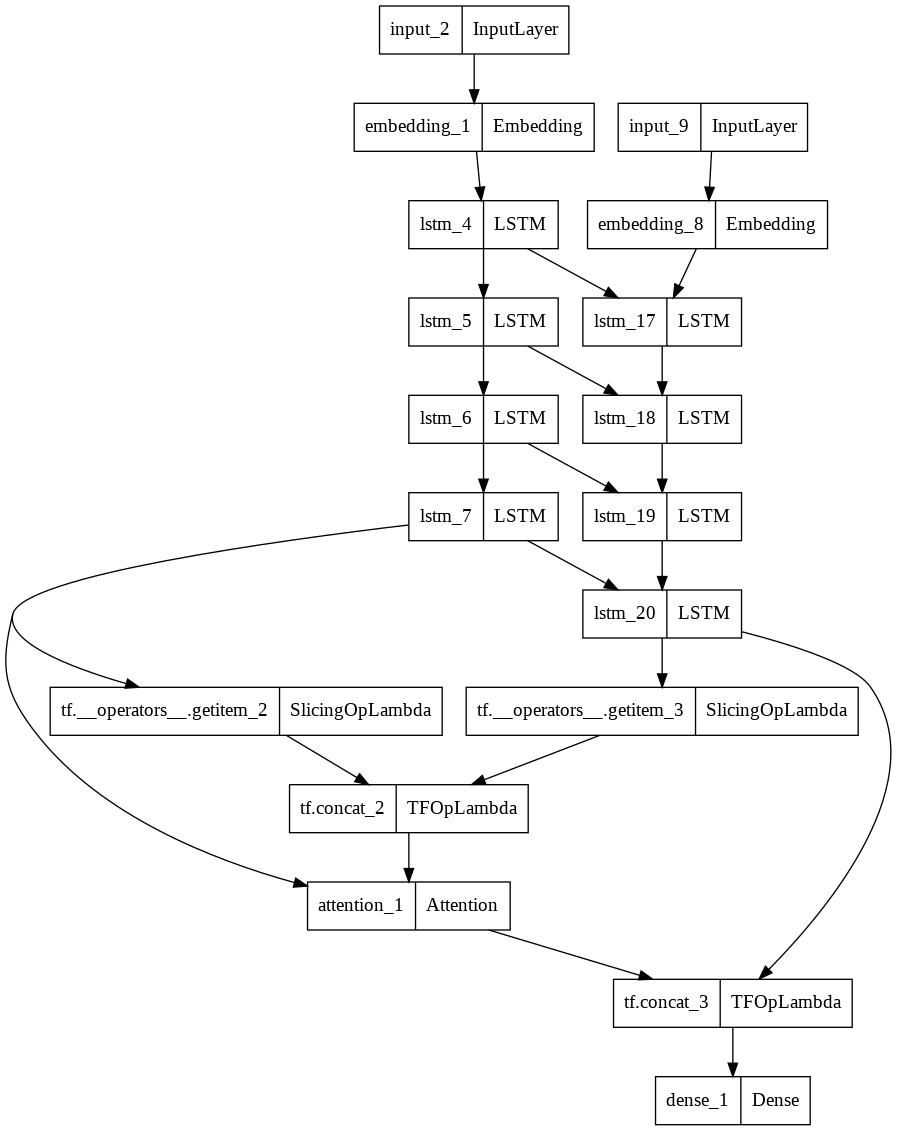

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', )

In [ ]:
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

EPOCH= 50
BATCH_SIZE = 64

filename = '/content/drive/MyDrive/voice_project/model/cp/checkpoint-epoch-{}-batch-{}-9/4층dropout04.h5'.format(EPOCH, BATCH_SIZE)

checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )
earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=4,         # ?회 Epoch동안 개선되지 않는다면 종료
                             )


In [ ]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, 
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),batch_size=BATCH_SIZE, epochs=EPOCH,callbacks=[checkpoint,earlystopping]
          )

Epoch 1/50
4800/4800 [==============================] - ETA: 0s - loss: 3.4404 - acc: 0.6001
Epoch 1: val_loss improved from inf to 3.16112, saving model to /content/drive/MyDrive/voice_project/model/cp/checkpoint-epoch-50-batch-64-9/4층dropout04.h5
4800/4800 [==============================] - 3521s 720ms/step - loss: 3.4404 - acc: 0.6001 - val_loss: 3.1611 - val_acc: 0.6170
Epoch 2/50
4800/4800 [==============================] - ETA: 0s - loss: 2.9952 - acc: 0.6204
Epoch 2: val_loss improved from 3.16112 to 2.96274, saving model to /content/drive/MyDrive/voice_project/model/cp/checkpoint-epoch-50-batch-64-9/4층dropout04.h5
4800/4800 [==============================] - 3459s 721ms/step - loss: 2.9952 - acc: 0.6204 - val_loss: 2.9627 - val_acc: 0.6266
Epoch 3/50
4800/4800 [==============================] - ETA: 0s - loss: 2.7672 - acc: 0.6289
Epoch 3: val_loss improved from 2.96274 to 2.84714, saving model to /content/drive/MyDrive/voice_project/model/cp/checkpoint-epoch-50-batch-64-9/4층dr

In [ ]:
model.save('/content/drive/MyDrive/nlp_project/model/songTolyric/lstm_attention_model_4층dropout04.h5')

## 훈련된 모델로 번역하기

* 평가 함수는 여기서 *교사 강요(teacher forcing)*를 사용하기 못하는 것을 제외하고는 훈련 루프와 비슷합니다. 각 마지막 시점(time step)에서 이전 디코더 인코더의 결과와 은닉 상태(hidden state)를 가진 예측 값을 디코더에 입력합니다.

    1. 번역하고자 하는 입력 문장이 인코더로 입력되어 인코더의 마지막 시점의 은닉 상태와 셀 상태를 얻습니다.
    2. 인코더의 은닉 상태와 셀 상태, 그리고 토큰 <sos>를 디코더로 보냅니다.
    3. 디코더가 토큰 <eos>가 나올 때까지 다음 단어를 예측하는 행동을 반복합니다.

In [ ]:
# 인코더 - 훈련과 동일 
encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])

In [ ]:
tf.keras.utils.plot_model(encoder_model, to_file='model.png', )

In [ ]:
# 디코더 

# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))

decoder_state_input_h1 = Input(shape=(hidden_units,))
decoder_state_input_c1 = Input(shape=(hidden_units,))

decoder_state_input_h2 = Input(shape=(hidden_units,))
decoder_state_input_c2 = Input(shape=(hidden_units,))

decoder_state_input_h3 = Input(shape=(hidden_units,))
decoder_state_input_c3 = Input(shape=(hidden_units,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c,
                         decoder_state_input_h1, decoder_state_input_c1,
                         decoder_state_input_h2, decoder_state_input_c2,
                         decoder_state_input_h3, decoder_state_input_c3]


encoder_state_h = Input(shape=(hidden_units,))
encoder_outputs2 = Input(shape =(None, hidden_units,))


# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
x, state_h1, state_c1 = decoder_lstm1(dec_emb2, initial_state=decoder_states_inputs[:2])
x, state_h2, state_c2 = decoder_lstm2(x, initial_state=decoder_states_inputs[2:4])
x, state_h3, state_c3 = decoder_lstm3(x, initial_state=decoder_states_inputs[4:6])
decoder_outputs2, state_h4, state_c4 = decoder_lstm4(x, initial_state=decoder_states_inputs[6:])
decoder_states2 = [state_h1, state_c1, state_h2, state_c2, state_h3, state_c3, state_h4, state_c4]


# Attention
S_ = tf.concat([encoder_state_h[:, tf.newaxis, :], decoder_outputs2[:, :-1, :]], axis=1) # query 

context_vector, att_score = attention([S_, encoder_outputs2], return_attention_scores = True)
decoder_concat = tf.concat([decoder_outputs2, context_vector], axis=-1)

# 모든 시점에 대해서 단어 예측 (Fully Connected)
decoder_outputs2 = decoder_dense(decoder_concat)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs, encoder_state_h, encoder_outputs2] + decoder_states_inputs,
    [decoder_outputs2, att_score] + decoder_states2)

In [ ]:
tf.keras.utils.plot_model(decoder_model, to_file='model.png', )

테스트 단계에서의 동작을 위한 decode_sequence 함수를 구현합니다. 
1. 입력 문장이 들어오면 인코더는 마지막 시점까지 전개하여 마지막 시점의 은닉 상태와 셀 상태를 리턴합니다. -> `states_value` 
2. 디코더의 초기 입력으로 <SOS>를 준비합니다. -> `target_seq`
3. 이 두 가지 입력을 가지고 while문 안으로 진입하여 이 두 가지를 디코더의 입력으로 사용합니다. 
4. 이제 디코더는 현재 시점에 대해서 예측합니다. 
    - 예측 벡터로부터 현재 시점의 예측 단어인 target_seq를 얻고, h와 c 이 두 개의 값은 states_value에 저장합니다. 
    - while문의 다음 루프. 즉, 두번째 시점의 디코더의 입력으로 다시 target_seq와 states_value를 사용합니다. 
    - 이를 현재 시점의 예측 단어로 <eos>를 예측하거나 번역 문장의 길이가 50이 넘는 순간까지 반복합니다. 
5. 각 시점마다 번역된 다어는 decoded_sentence에 누적하여 저장하였다가 최종 번역 시퀀스로 리턴합니다.

In [ ]:
def decode_sequence(sentence):
    # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
    max_src_len, max_tar_len  = encoder_input.shape[1], decoder_input.shape[1]

    attention_plot = np.zeros((max_tar_len, max_src_len))

    sentence = preprocess_kor_sentence(sentence)
    tokens = sentence.split(" ")
    inputs = tokenizer_lylic.texts_to_sequences([tokens])

    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                            maxlen=max_src_len,
                                                            padding='post')
    encoder_test, states_value = encoder_model.predict(inputs)

    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_to_index['<sos>']
    
    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    for t in range(max_tar_len):
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, att_score, h1, c1, h2, c2, h3, c3, h4, c4 = decoder_model.predict([target_seq, states_value[0], encoder_test] + states_value)
        # tar_to_index 2808
  

        # 어텐션 가중치 시각화를 위해 저장 
        att_score = tf.reshape(att_score, (-1, ))
        attention_plot[t] = att_score.numpy() 

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]
  
        # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char


        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [ h1, c1, h2, c2, h3, c3, h4 ,c4]

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if sampled_char == '<eos>':
            break 

    return sentence, decoded_sentence, attention_plot

결과 확인을 위한 함수를 만듭니다.

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_to_index['<eos>']):
    # if(encoded_word != 0 and encoded_word != tar_to_index['<sos>'] and encoded_word != tar_to_index['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

In [ ]:
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence):
    # you need to change the fname based on your system, and the Chinese can be displayed in the plot
    # font = FontProperties(fname=r"./data/TaipeiSansTCBeta-Regular.ttf", size=14)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    # set the x-tick/y-tick labels with list of string labels
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation = 90)
    ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

    # set tick locators
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [ ]:
def translate(sentence):
  sentence, result, attention_plot = decode_sequence(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

"""  attention_plot = attention_plot[:len(result.split(' '))-2, :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))"""

In [ ]:
translate('번역기를 만드는 것은 재미있어.')

In [ ]:
translate('집에 가고 싶다.')

In [ ]:
translate('당신의 직업은 무엇입니까?')

In [ ]:
def translate_train(seq_index):
  input_seq = encoder_input_train[seq_index: seq_index + 1]

  sentence = seq_to_src(encoder_input_train[seq_index]).strip()
  _, result, attention_plot = decode_sequence(sentence)

  print('Input: %s' % (sentence))
  print("Right translation :",seq_to_tar(decoder_input_train[seq_index]))
  print('Predicted translation: {}'.format(result))

"""  attention_plot = attention_plot[:len(result.split(' '))-2, :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))"""

In [ ]:
translate_train(11)

In [ ]:
for seq_index in [10, 203, 500, 900, 8003]:
  translate_train(seq_index)
  print("-"*50)

In [ ]:
def translate_test(seq_index):
  input_seq = encoder_input_test[seq_index: seq_index + 1]

  sentence = seq_to_src(encoder_input_test[seq_index]).strip()
  _, result, attention_plot = decode_sequence(sentence)

  print('Input: %s' % (sentence))
  print("Right translation :",seq_to_tar(decoder_input_train[seq_index]))
  print('Predicted translation: {}'.format(result))

  #attention_plot = attention_plot[:len(result.split(' '))-2, :len(sentence.split(' '))]
  #plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
for seq_index in [10, 200, 303, 1005]:
  translate_test(seq_index)
  print("-"*50)

# test

In [ ]:
len(encoder_input_test)

In [ ]:
import numpy as np

a = np.random.randint(30000, size=1000)
print(a)

In [ ]:
for seq_index in a:
  translate_test(seq_index)
  print("-"*50,seq_index)

In [ ]:
b="오- 내가 웃고 있나요?모두 거짓이겠죠? 날 보는 이들의 눈빛 속에는 (oh!) 슬픔이 젖어있는데. 헤이- 내 이름은 광대, 내 직업은 수많은 관객, 그 앞에 웃음을 파는 일 슬퍼도 웃으며 내 모습을 감추는 게 철칙. 오- 이런 내 처질, 손가락질 하며 날 모욕해도 더 크게 웃고 난 땀으로 목욕하고 음악이 꺼지고 막이 내리고 밤이 오면 별빛에 몸을 씻고 눈부시게 광낸 구두를 신고 달에게 청혼하듯 손을 내밀어 얼음 위를 미끄러지듯 앞으로 달려 (아무도) 아무도 모르게 조용히 흐르는 이 시간에 외롭게 홀로 핀 꽃 한 송이에 난 반해 사랑을 나누려 나는 간다네 세상을 넘어 시간을 멈추고 세상을 넘어 신나게 춤을 춰봐 세상을 넘어 모두가 같은 높이에서 그래 그래 그렇게 내가 웃고있나요 모두 거짓이겠죠 날 보는 이들의 눈빛속에는 슬픔이 젖어있는데 무대 위에 서면 우린 때론 정반대 내가 관객이 돼. 사람들의 얼굴에 상상의 그림을 그려 물감을 뿌려 저 불타는 이십대의 청춘은 내일이면 이 사회의 첫 줄을 이력서 쓰며 인생을 시험보고 저 순진한 사랑의 초보 애인있는 남자와 눈 맞어 사랑에 빠져 슬픔을 기다리네 (come on baby) 너와 나 모두 왕의 옷을 입어도 신하가 되버리는 현실에 혼신에 힘을 다해 헌신에 오늘 술 한잔하면 내일은 물 한잔으로 버텨야하지만, 일단은 오늘 또 마시네 아픔이 싹 가시네 세상을 넘어 시간을 멈추고 세상을 넘어 신나게 춤을 춰봐 세상을 넘어 모두가 같은 높이에서 그래 그래 그렇게 내가 웃고있나요 모두 거짓이겠죠 날 보는 이들의 눈빛속에는 슬픔이 젖어있는데 내가 웃고있나요 모두 거짓이겠죠 날 보는 이들의 눈빛속에는 슬픔이 젖어있는데"
translate(b)

In [ ]:
c='동해 물과 백두산이 마르고 닳도록 하느님이 보우하사 우리나라 만세. 무궁화 삼천리 화려 강산 대한 사람 대한으로 길이 보전하세'
translate(c)